#Integrantes de la tarea

Integrantes del grupo:

* Integrante 1:Matias Rodriguez U. Rut: 18362815-1
* Integrante 2:Paula Canales G. Rut:18845155-1
* Integrante 3:Sebastián Alday Rut:18294095-k
* Integrante 4:Álvaro Neira R. Rut:13757209-5

# Importación de Librerias

Estas son las bibliotecas y módulos necesarios.

In [119]:
import pandas as pd
import re

import spacy
import nltk
import sklearn
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd
import random

# Datos Necesarios

Descargamos los datos necesarios para las actividades

In [120]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/proveedoresA.txt
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/other_vhosts_access.log
nltk.download('stopwords')
nltk.download('wordnet')
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp_es = es_core_news_sm.load()

--2021-12-02 21:09:28--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29482924 (28M) [text/plain]
Saving to: ‘aysen.csv.3’

aysen.csv.3         100%[===================>]  28.12M   145MB/s    in 0.2s    

2021-12-02 21:09:30 (145 MB/s) - ‘aysen.csv.3’ saved [29482924/29482924]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 16.2 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


# 1 Limpieza de la base de datos 


##Dataset

In [121]:
aysen = pd.read_csv("aysen.csv", sep=";", na_values=["Otro",""])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
aysen.head()

,FECHA_NAC,SEXO,PRESTA_MIN,PLANO,EXTREMIDAD,PRESTA_EST,F_ENTRADA,ESTAB_ORIG,ESTAB_DEST,F_SALIDA,C_SALIDA,E_OTOR_AT,PRESTA_MIN_SALIDA,REGION,COMUNA,SOSPECHA_DIAG
0,1985,2,09-001-0,NaN,NaN,ENDODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca
1,1946,1,09-004-0,NaN,NaN,PERIODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Periodontitis cronica
2,1937,2,09-006-0,NaN,NaN,REHABILITACION: PROTESIS REMOVIBLE,31-12-17,25-301,25-100,2018-01-03 00:00:00,1.0,25-100,09-006-0,11,11101,Otras afecciones especificadas de los dientes ...
3,1955,2,07-208-0,NaN,NaN,NEUROCIRUGIA,30-12-17,25-300,25-100,NaN,NaN,NaN,NaN,11,11101,"Trastornos de disco lumbar y otros, con radicu..."
4,1997,2,09-001-0,NaN,NaN,ENDODONCIA,30-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca


##1.1 Creación del DK10

###Especialidades con más de 10.000 derivaciones

In [123]:
D10K_ranking=pd.DataFrame(aysen[["SOSPECHA_DIAG","PRESTA_EST"]].PRESTA_EST.value_counts(dropna=False))
D10K_ranking=D10K_ranking.loc[D10K_ranking["PRESTA_EST"]>10000]
D10K_ranking


,PRESTA_EST
TRAUMATOLOGIA,24004
OFTALMOLOGIA,21482
CIRUGIA ADULTO,17321
OTORRINOLARINGOLOGIA,13663
NEUROLOGIA,12316
MEDICINA INTERNA,11408
GINECOLOGIA,10871
ENDODONCIA,10225


In [124]:
list(D10K_ranking.index)

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

###Definición DK10

Se necesita de un ciclo para recuperar la columna "SOSPECHA_DIAG" a partir de las especialidades seleccionadas por el rankin

In [125]:

z1=0
z2=0
presta=[]
sospecha=[]
for u in aysen["PRESTA_EST"]:
  for v in list(D10K_ranking.index):
    if u==v:
      #print(u)
      presta.append(u)
      sospecha.append(aysen["SOSPECHA_DIAG"].iloc[z1])
    z2=z2+1 
  z1=z1+1

Se concatenan y se crea DK10

In [126]:
DK10=pd.concat([pd.DataFrame(sospecha).rename(columns={0:"SOSPECHA_DIAG"}),pd.DataFrame(presta).rename(columns={0:"PRESTA_EST"})],axis=1)
DK10=DK10.reset_index(drop=True)

In [127]:
DK10

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Celulitis y absceso de boca,ENDODONCIA
2,FISURA ANAL,CIRUGIA ADULTO
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
4,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
121285,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA
121286,Consulta no Especificada,MEDICINA INTERNA
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
121288,Consulta no Especificada,CIRUGIA ADULTO


##1.2 Transformación del texto con patrones regulares

In [128]:
import re

In [129]:
# Corrígeme
# pattern = r"""(?x)                   # set flag to allow verbose regexps
#               (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
#               |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages
#               |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
#               |(?:[+/\-@&*])         # special characters with meanings
#             """

pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
              |\$?\d+(?:[.,]\d+)?%?  # numbers, incl. currency and percentages
              |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
              |(?:[+/\-@&*¡!])     # special characters with meanings
            """
pattern2 = r"""                 # set flag to allow verbose regexps
              (\s)([A-Z])         # abbreviations, e.g. U.S.A.

            """
replace= r"""$1\l$2"""
def cambiate(text):
  hola=nltk.regexp_tokenize(text, pattern)
  holanuevo=[]
  for word in hola:
      holanuevo.append(re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), word) )
  separator = ' '
  hola2=separator.join(holanuevo)
  return hola2


In [130]:
cambiate(DK10["SOSPECHA_DIAG"].iloc[121285])

'hipertension esencial primaria'

Se hace un experimento, el programa debería quitar la ","

In [131]:
DK10["SOSPECHA_DIAG"].iloc[121285]="HIPERTENSION ESENCIAL, PRIMARIA"

In [132]:
print(DK10["SOSPECHA_DIAG"].iloc[121285])

HIPERTENSION ESENCIAL, PRIMARIA


In [133]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate(x.SOSPECHA_DIAG), axis=1)

In [134]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis y absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,celulitis y absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,fisura anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada
...,...,...,...
121285,"HIPERTENSION ESENCIAL, PRIMARIA",MEDICINA INTERNA,hipertension esencial primaria
121286,Consulta no Especificada,MEDICINA INTERNA,consulta no especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,hernias del nucleo pulposo
121288,Consulta no Especificada,CIRUGIA ADULTO,consulta no especificada


##1.3 Transformación del texto quitando los stopwords

In [135]:
nltk_stopwords = nltk.corpus.stopwords.words('spanish')
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

stop_words_union = set(list(nltk_stopwords) + list(spacy_stopwords))
stop_words_final = []
for word in stop_words_union:
  if word not in spacy_stopwords:
    stop_words_final.append(word)
  if word not in nltk_stopwords:
    stop_words_final.append(word)


def cambiate2(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    if word not in stop_words_final:
      nuevohola.append(word)
  separator = ' '
  hola2=separator.join(nuevohola)
  return hola2

In [136]:
len(stop_words_final)

544

Se hace un experimento colocando un stopword, en este caso "cerca"

In [137]:
DK10["SOSPECHA_DIAG"].iloc[121285]="hipertension esencial primaria cerca"

In [138]:
print(DK10["SOSPECHA_DIAG"].iloc[121285])

hipertension esencial primaria cerca


Después de ocupar la función, efectivamente se quita esta palabra

In [139]:
print(cambiate2(DK10["SOSPECHA_DIAG"].iloc[121285]))

hipertension esencial primaria


Se hace la transformación completa.

In [140]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate2(x.SOSPECHA_DIAG_TRANSFORMADO), axis=1)

Se puede apreciar que se elimina la stopword, como también se puede concluir que se deberían quitar las demás en el caso de que las haya.

In [141]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,celulitis absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,fisura anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada
...,...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA,hipertension esencial primaria
121286,Consulta no Especificada,MEDICINA INTERNA,consulta no especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,hernias del nucleo pulposo
121288,Consulta no Especificada,CIRUGIA ADULTO,consulta no especificada


##1.4 Transformación del texto con stemmer

In [142]:
stemmer = nltk.stem.SnowballStemmer("spanish")
#lemmatizer = nltk.stem.WordNetLemmatizer() no hay en español

def cambiate3(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    nuevohola.append(stemmer.stem(word))
  separator = ' '
  hola2=separator.join(nuevohola)
  return hola2

In [143]:
stemmer.stem("especificada")

'especific'

In [144]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate3(x.SOSPECHA_DIAG_TRANSFORMADO), axis=1)

In [145]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis absces de boc
1,Celulitis y absceso de boca,ENDODONCIA,celulitis absces de boc
2,FISURA ANAL,CIRUGIA ADULTO,fisur anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical agud origin en la pulp
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especific
...,...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA,hipertension esencial primari
121286,Consulta no Especificada,MEDICINA INTERNA,consult no especific
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,herni del nucle pulpos
121288,Consulta no Especificada,CIRUGIA ADULTO,consult no especific


##DK10 Crudo y Procesado

In [146]:
DK10_crudo=DK10[["SOSPECHA_DIAG","PRESTA_EST"]].copy()
DK10_crudo

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Celulitis y absceso de boca,ENDODONCIA
2,FISURA ANAL,CIRUGIA ADULTO
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
4,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA
121286,Consulta no Especificada,MEDICINA INTERNA
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
121288,Consulta no Especificada,CIRUGIA ADULTO


In [147]:
DK10_procesado=DK10[["SOSPECHA_DIAG_TRANSFORMADO","PRESTA_EST"]].copy()
DK10_procesado=DK10_procesado.rename(columns={"SOSPECHA_DIAG_TRANSFORMADO":"SOSPECHA_DIAG"})
DK10_procesado

,SOSPECHA_DIAG,PRESTA_EST
0,celulitis absces de boc,ENDODONCIA
1,celulitis absces de boc,ENDODONCIA
2,fisur anal,CIRUGIA ADULTO
3,periodontitis apical agud origin en la pulp,ENDODONCIA
4,osteomielitis no especific,TRAUMATOLOGIA
...,...,...
121285,hipertension esencial primari,MEDICINA INTERNA
121286,consult no especific,MEDICINA INTERNA
121287,herni del nucle pulpos,NEUROLOGIA
121288,consult no especific,CIRUGIA ADULTO


#  2 Análisis no-supervisado y visualización



* Utilice en esta sección la salida de la sección de limpieza, o el texto crudo.



### 2.1 Visualice utilizando wordcloud las palabras más comunes para cada categoría D10K. 



* En esta parte me baso en **2-normalization_and_vector_semantics.sol.ipynb**

* En esta seccion utilizamos los stopwords calculados en el punto 1.3

In [148]:
stopwords_aysen = stop_words_union

In [150]:
def plot_wordcloud_from_specialty(dataset, specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_aysen.get_feature_names_out(),x_aysen.toarray()[dataset.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

In [149]:
tfidf_vectorizer_aysen = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_aysen,max_df=0.20)
x_aysen = tfidf_vectorizer_aysen.fit_transform(DK10_procesado.SOSPECHA_DIAG)

In [153]:
tfidf_vectorizer_raw = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_aysen,max_df=0.20)
x_raw = tfidf_vectorizer_raw.fit_transform(DK10_crudo.SOSPECHA_DIAG)
def plot_wordcloud_from_specialty_raw(dataset, specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_raw.get_feature_names_out(),x_raw.toarray()[dataset.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

DK10_procesado: TRAUMATOLOGIA


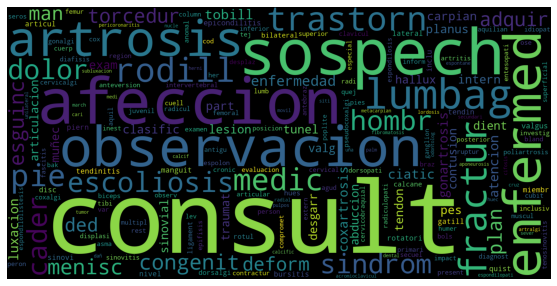


DK10_crudo: TRAUMATOLOGIA


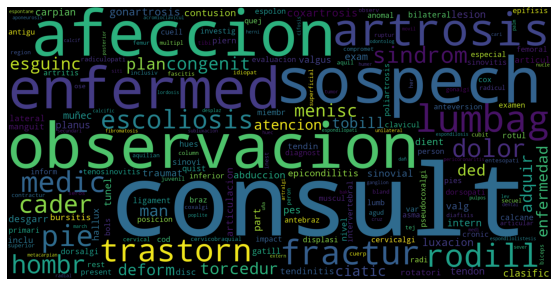


DK10_procesado: OFTALMOLOGIA


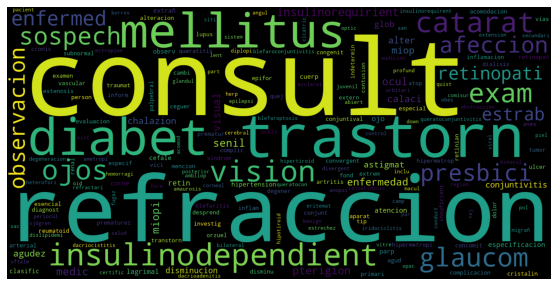


DK10_crudo: OFTALMOLOGIA


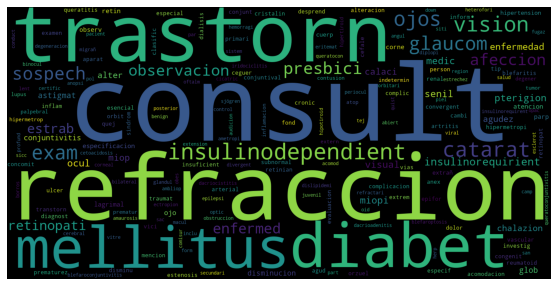


DK10_procesado: CIRUGIA ADULTO


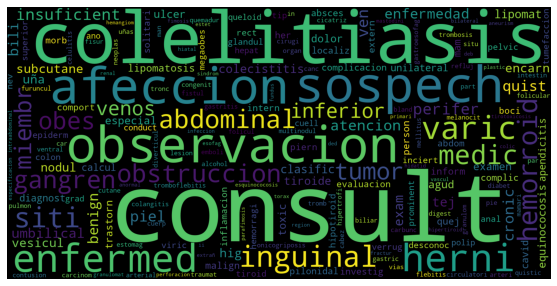


DK10_crudo: CIRUGIA ADULTO


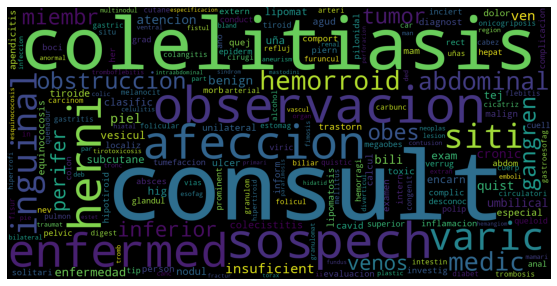


DK10_procesado: OTORRINOLARINGOLOGIA


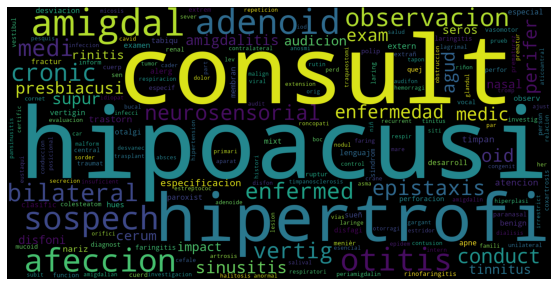


DK10_crudo: OTORRINOLARINGOLOGIA


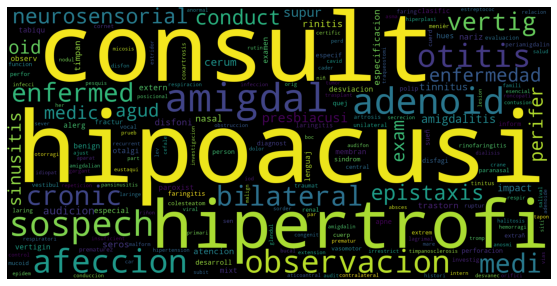


DK10_procesado: NEUROLOGIA


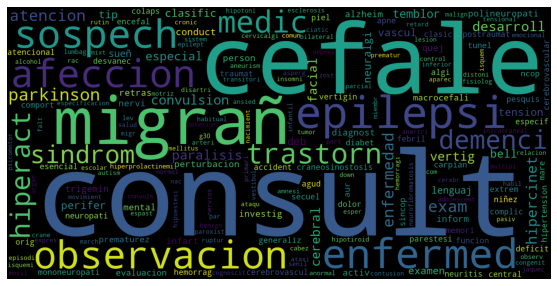


DK10_crudo: NEUROLOGIA


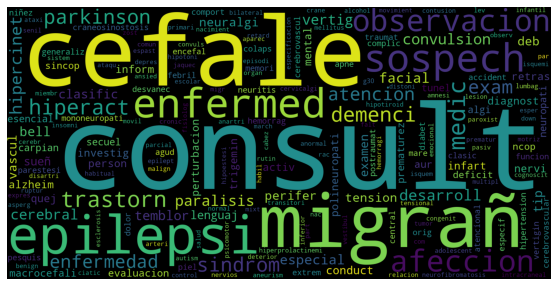


DK10_procesado: MEDICINA INTERNA


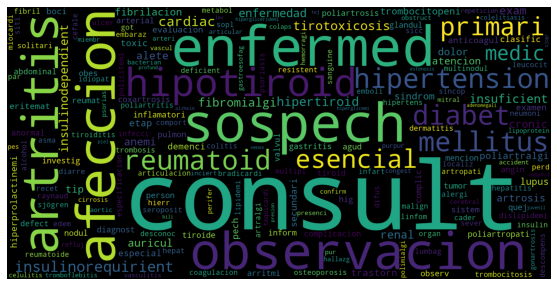


DK10_crudo: MEDICINA INTERNA


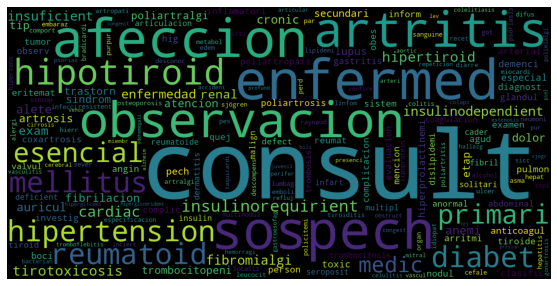


DK10_procesado: GINECOLOGIA


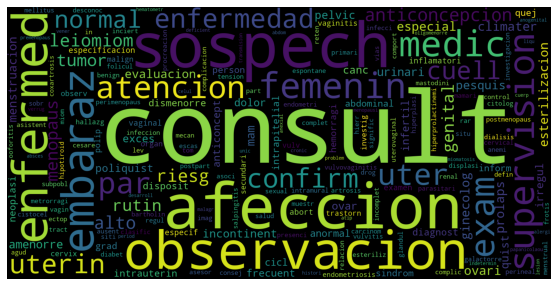


DK10_crudo: GINECOLOGIA


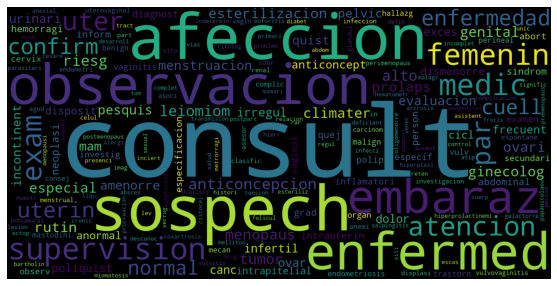


DK10_procesado: ENDODONCIA


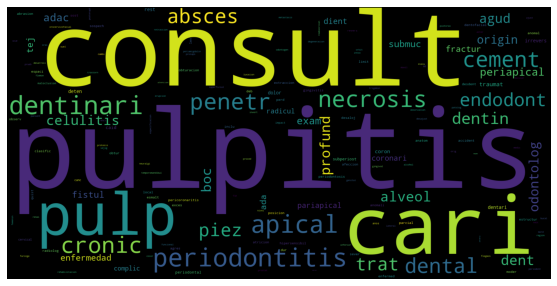


DK10_crudo: ENDODONCIA


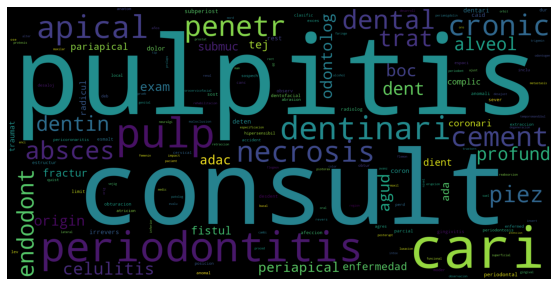

In [154]:
for specialty in list(D10K_ranking.index):
  print(f"DK10_procesado: {specialty}")
  plot_wordcloud_from_specialty(DK10_procesado, specialty)
  print(f"")
  print(f"DK10_crudo: {specialty}")
  plot_wordcloud_from_specialty(DK10_crudo, specialty)
  print(f"")